# Implementation

## General Imports

In [1]:
import numpy as np
import sys, os, time
import torch
import utils
from torchvision import datasets, transforms
from sklearn.utils import shuffle
from tensorboardX import SummaryWriter
import traceback
import importlib
import global_params
import monitor
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import time

## Settings

#### Seeding Settings

In [2]:
def define_seed(args):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

#### Global Settings

In [3]:
dataloader = None
approach = None
network = None
use_cuda = None

#### CUDA Settings

In [4]:
def load_cuda_settings():
    global use_cuda
    if torch.cuda.is_available():
        use_cuda = True
        torch.cuda.manual_seed(args.seed)
    else:
        use_cuda = False
        print('[CUDA unavailable]')

#### Experiment Settings

In [5]:
def load_experiment(args):
    global dataloader
    if args.experiment == 'cifar':
        from dataloaders import cifar as dataloader
    elif args.experiment == 'mixture':
        from dataloaders import mixture as dataloader
    elif args.experiment == 'mnist2':
        from dataloaders import mnist2 as dataloader
    elif args.experiment == 'pmnist':
        from dataloaders import pmnist as dataloader
    else:
        dataloader = None
        print('Dataset not supported')

#### Network Settings

In [6]:
def load_network_and_approach(args, approaches_dir='approaches', networks_dir='networks'):
    global network, approach
    network = importlib.import_module('.'+args.network, package=networks_dir)
    approach = importlib.import_module('.'+args.approach, package=approaches_dir)

## Initialize Training

In [7]:
def train(args):
    # load settings
    define_seed(args)
    load_cuda_settings()
    load_experiment(args)
    load_network_and_approach(args)
    
    tstart=time.time()

    # Load
    print('Load data...')
    data, taskcla, inputsize = dataloader.get(seed=args.seed)
    print('Input size =', inputsize, '\nTask info =', taskcla)

    # Inits
    print('Inits...')
    net = network.Net(inputsize, taskcla)
    if use_cuda:
        net = net.cuda()

    params = utils.calculate_parameters(net)
    print('Num parameters = %s' % (params))
    if args.print_stats:
        utils.print_model_report(net, params)

    appr = approach.Appr(net, nepochs=args.nepochs, lr=args.lr, args=args, use_cuda=use_cuda)
    if args.print_stats:
        utils.print_optimizer_config(appr.optimizer)
    print('-' * 100)

    try:
        # Loop tasks
        acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
        lss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
        for t, ncla in taskcla:
            print('*' * 100)
            print('Task {:2d} ({:s})'.format(t, data[t]['name']))
            print('*' * 100)

            if args.approach == 'joint':
                # Get data. We do not put it to GPU
                if t == 0:
                    xtrain = data[t]['train']['x']
                    ytrain = data[t]['train']['y']
                    xvalid = data[t]['valid']['x']
                    yvalid = data[t]['valid']['y']
                    task_t = t * torch.ones(xtrain.size(0)).int()
                    task_v = t * torch.ones(xvalid.size(0)).int()
                    task = [task_t, task_v]
                else:
                    xtrain = torch.cat((xtrain, data[t]['train']['x']))
                    ytrain = torch.cat((ytrain, data[t]['train']['y']))
                    xvalid = torch.cat((xvalid, data[t]['valid']['x']))
                    yvalid = torch.cat((yvalid, data[t]['valid']['y']))
                    task_t = torch.cat((task_t, t * torch.ones(data[t]['train']['y'].size(0)).int()))
                    task_v = torch.cat((task_v, t * torch.ones(data[t]['valid']['y'].size(0)).int()))
                    task = [task_t, task_v]
            else:
                # Get data
                xtrain = data[t]['train']['x']
                ytrain = data[t]['train']['y']
                xvalid = data[t]['valid']['x']
                yvalid = data[t]['valid']['y']
                if use_cuda:
                    xtrain = xtrain.cuda()
                    ytrain = ytrain.cuda()
                    xvalid = xvalid.cuda()
                    yvalid = yvalid.cuda()

                task = t

            # Train
            appr.train(task, xtrain, ytrain, xvalid, yvalid)
            print('-' * 100)

            # Test
            for u in range(t + 1):
                xtest = data[u]['test']['x']
                ytest = data[u]['test']['y']
                if use_cuda:
                    xtest = xtest.cuda()
                    ytest = ytest.cuda()
                test_loss, test_acc = appr.eval(u, xtest, ytest)
                print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                              100 * test_acc))
                acc[t, u] = test_acc
                lss[t, u] = test_loss

            # Save
            print('Save at ' + args.output)
            np.savetxt(args.output, acc, '%.4f')
    except:
        traceback.print_exc()
        return net

    # Done
    print('*' * 100)
    print('Accuracies =')
    for i in range(acc.shape[0]):
        print('\t', end='')
        for j in range(acc.shape[1]):
            print('{:5.1f}% '.format(100 * acc[i, j]), end='')
        print()
    print('*' * 100)
    print('Done!')

    print('[Elapsed time = {:.1f} h]'.format((time.time() - tstart) / (60 * 60)))

    if hasattr(appr, 'logs'):
        if appr.logs is not None:
            # save task names
            from copy import deepcopy
            appr.logs['task_name'] = {}
            appr.logs['test_acc'] = {}
            appr.logs['test_loss'] = {}
            for t, ncla in taskcla:
                appr.logs['task_name'][t] = deepcopy(data[t]['name'])
                appr.logs['test_acc'][t] = deepcopy(acc[t, :])
                appr.logs['test_loss'][t] = deepcopy(lss[t, :])
            # pickle
            import gzip
            import pickle
            with gzip.open(os.path.join(appr.logpath), 'wb') as output:
                pickle.dump(appr.logs, output, pickle.HIGHEST_PROTOCOL)

    return net

## Experiments

In [8]:
args = global_params.args
args.seed = 0
args.experiment = 'cifar'
args.approach = 'si_xda'
args.network = 'alexnet_'
args.output = 'res/'+args.network+args.experiment+'_'+args.approach+'_'+str(args.seed)+'.txt'
args.comment = 'alexnet_'+args.approach

# change due to other naming convention in approaches
args.network = args.network + args.approach
args.print_stats = False
args.nepochs = 200
args.lr = 0.05
args.enable_logging = True
args.log_steps = 1000
args.logger = monitor.Logger(args)

In [9]:
net = train(args)

Load data...
Task order = [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]
Input size = [3, 32, 32] 
Task info = [(0, 2), (1, 20), (2, 2), (3, 20), (4, 2), (5, 20), (6, 20), (7, 2), (8, 2), (9, 20)]
Inits...
Num parameters = 7.6M
Setting parameters to c-0.1, xi-0.001, decay-0.5
----------------------------------------------------------------------------------------------------
****************************************************************************************************
Task  0 (cifar10-2)
****************************************************************************************************
tensor(0.1236, device='cuda:0', grad_fn=<MulBackward0>)
| Epoch   1, time= 19.9ms/  5.1ms | Train: loss=1.844, acc= 65.5% | Valid: loss=1.828, acc= 67.1% | *
| Epoch   2, time= 14.5ms/  4.5ms | Train: loss=1.581, acc= 70.5% | Valid: loss=1.563, acc= 72.2% | *
| Epoch   3, time= 14.7ms/  4.4ms | Train: loss=1.353, acc= 78.1% | Valid: loss=1.324, acc= 79.8% | *
| Epoch   4, time= 14.4ms/  4.4ms | Train: loss=1.245,

In [10]:
torch.save(net.state_dict(), "models/" + args.approach + ".model")

## Data Visualization

In [13]:
t = 0
data_raw, taskcla, inputsize = dataloader.get(seed=args.seed)
data_train = data_raw[t]['train']['x']

Task order = [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]


In [14]:
args.approach = 'si_xda'
args.network = 'alexnet_' + args.approach
load_network_and_approach(args)
net = network.Net(inputsize, taskcla)
net.load_state_dict(torch.load("models/si_xda.model"))
net.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2)
  (drop2): Dropout(p=0.5)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (last): ModuleList(
    (0): Linear(in_features=2048, out_features=2, bias=True)
    (1): Linear(in_features=2048, out_features=20, bias=True)
    (2): Linear(in_features=2048, out_features=2, bias=True)
    (3): Linear(in_features=2048, out_features=20, bias=True)
    (4): Linear(in_features=2048, out_features=2, bias=True)
    (5): Linear(in_features=2048, out_features=20, bias=True)
    (6): Linear(in_features=2048, out_features=20, bias=True)
    (7): Linear(in_features=2048, out_features=2, bias=True)
    (8): Linear(in_features=

In [194]:
args.approach = 'sgd'
args.network = 'alexnet_' + args.approach
load_network_and_approach(args)
sgd_net = network.Net(inputsize, taskcla)
sgd_net.load_state_dict(torch.load("models/sgd.model"))
sgd_net.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (drop1): Dropout(p=0.2)
  (drop2): Dropout(p=0.5)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (last): ModuleList(
    (0): Linear(in_features=2048, out_features=2, bias=True)
    (1): Linear(in_features=2048, out_features=20, bias=True)
    (2): Linear(in_features=2048, out_features=2, bias=True)
    (3): Linear(in_features=2048, out_features=20, bias=True)
    (4): Linear(in_features=2048, out_features=2, bias=True)
    (5): Linear(in_features=2048, out_features=20, bias=True)
    (6): Linear(in_features=2048, out_features=20, bias=True)
    (7): Linear(in_features=2048, out_features=2, bias=True)
    (8): Li

In [15]:
mean = torch.from_numpy(np.array([125.3, 123.0, 113.9], dtype=np.float32))
std = torch.from_numpy(np.array([63.0, 62.1, 66.7], dtype=np.float32))

In [16]:
data_train_img = data_train.transpose(1, 3)
data_train_img = data_train_img.transpose(1, 2)

In [17]:
data_train_img.shape

torch.Size([9000, 32, 32, 3])

In [18]:
data_train_img_norm = (data_train_img[:,:,:,:]*std + mean)/255.0

### Visualize Image and Activation Maps

In [242]:
sample_no = 77
neuron_no = 30
cmap = "PRGn"
x = data_train[sample_no].view(1, 3, 32, 32).cuda()

### XdA Forward

In [243]:
c1_act = net.conv1(x.cpu())
c1_gated_act = net.c1_xda(c1_act, t)
c1_act_np = c1_act[0][neuron_no].data.cpu().numpy()
c1_gated_act_np = c1_gated_act[0][neuron_no].data.cpu().numpy()


h = net.drop1(c1_gated_act)
h = net.maxpool(h)
c2_act = net.conv2(h)
c2_gated_act = net.c2_xda(c2_act, t)
c2_act_np = c2_act[0][neuron_no].data.cpu().numpy()
c2_gated_act_np = c2_gated_act[0][neuron_no].data.cpu().numpy()

### SGD Forward

In [248]:
c1_act = sgd_net.conv1(x.cpu())
c1_gated_act = sgd_net.relu(c1_act)
c1_act_np = c1_act[0][neuron_no].data.cpu().numpy()
c1_gated_act_np = c1_gated_act[0][neuron_no].data.cpu().numpy()


h = sgd_net.drop1(c1_gated_act)
h = sgd_net.maxpool(h)
c2_act = sgd_net.conv2(h)
c2_gated_act = sgd_net.relu(c2_act)
c2_act_np = c2_act[0][neuron_no].data.cpu().numpy()
c2_gated_act_np = c2_gated_act[0][neuron_no].data.cpu().numpy()

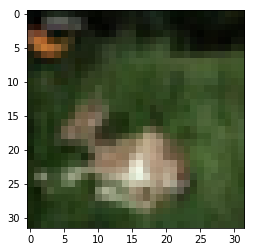

In [249]:
plt.imshow(data_train_img_norm[sample_no])

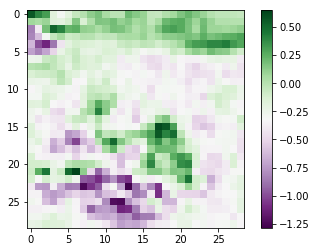

In [250]:
plt.imshow(c1_act_np, cmap=cmap)
plt.colorbar()

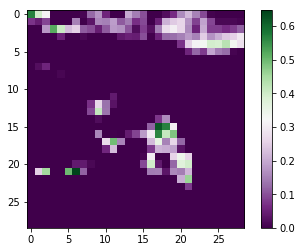

In [251]:
plt.imshow(c1_gated_act_np, cmap=cmap)
plt.colorbar()

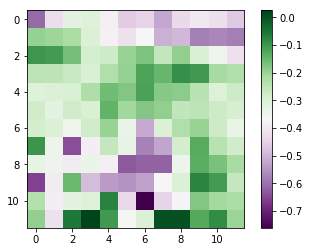

In [252]:
plt.imshow(c2_act_np, cmap=cmap)
plt.colorbar()

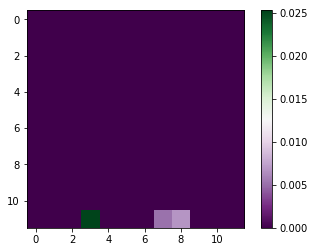

In [253]:
plt.imshow(c2_gated_act_np, cmap=cmap)
plt.colorbar()

### Visualize Weights

In [ ]:
c1_weights_img = net.conv1.weight.data

In [ ]:
c1_weights_img_np = c1_weights_img.cpu().numpy()

In [ ]:
c1_weights_img_np.shape

In [ ]:
plt.imshow(c1_weights_img_np[20][0], cmap="Greys")